# Step 1: Data Preparation


In [37]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
import requests
import urllib
import emoji
import json
import re

nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/waseem/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [38]:
# Load data

## Fetch listing data from our (SMARE) API
data = requests.get("https://smare.lryanle.com/api/ext/listings")

if data.status_code == 200:
    data = data.json()

    if data["success"]:
        flagged_listings = pd.DataFrame(data["data"]["flagged"])
        not_flagged_listings = pd.DataFrame(data["data"]["notflagged"])

        flagged_listings["flagged"] = True
        not_flagged_listings["flagged"] = False

        data = pd.concat([flagged_listings, not_flagged_listings], ignore_index=True)

        print("Data retrieved and parsed successfully!")
        print(f"Number of flagged listings: {len(flagged_listings)}")
        print(f"Number of not flagged listings: {len(not_flagged_listings)}")
    else:
        print("API returned an unsuccessful status.")
else:
    print("Failed to retrieve data. Status code:", data.status_code)

Data retrieved and parsed successfully!
Number of flagged listings: 367
Number of not flagged listings: 700


In [40]:
# Listing MSRP (KBB) Data
with open("l_kbb_prices.json", "r") as kbb_file:
    kbb_prices = json.load(kbb_file)

def get_listed_price(listing):
    makemodel = f"{listing['make']} {listing['model']} {listing['year']}".lower()
    fallback_makemodel = (
        f"{listing['make']} {listing['model'].split(' ')[0]} {listing['year']}".lower()
    )

    if makemodel in kbb_prices:
        return listing["price"] - int(kbb_prices[makemodel])
    elif fallback_makemodel in kbb_prices:
        return listing["price"] - int(kbb_prices[fallback_makemodel])
    else:
        print(makemodel)
        return None


def scrape_kbb_price(make, model, year):
    try:
        make_url_part = make.lower().replace(" ", "-")
        model_url_part = model.lower().replace(" ", "-")
        search_url = f"https://www.kbb.com/{make_url_part}/{model_url_part}/{year}/"
        response = requests.get(search_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        scripts = soup.find_all("script")
        for script in scripts:
            if script.string and '"nationalBaseDefaultPrice"' in script.string:
                start_index = (
                    script.string.find('"nationalBaseDefaultPrice"')
                    + len('"nationalBaseDefaultPrice"')
                    + 1
                )
                end_index = script.string.find(",", start_index)
                kbb_price = script.string[start_index:end_index]

                return int(kbb_price)

        return None
    except Exception as e:
        return None
    
data["listed_price"] = data.apply(lambda row: get_listed_price(row), axis=1)
print(f"Number of listings with no KBB price: {data['listed_price'].isnull().sum()}")

In [ ]:
# Calculate the price delta between price and listed_price


In [43]:
# NHTSA Theft Rate Data
with open("./n_nhtsa_theft_rates.json") as nhtsa_theft_file:
    nhtsa_theft_rates = json.load(nhtsa_theft_file)

def theft_rate(listing):
    makemodel = f"{listing['make']} {listing['model']} {listing['year']}".lower()
    fallback_makemodel = f"{listing['make']} {listing['model'].split(' ')[0]} {listing['year']}".lower()

    if makemodel in nhtsa_theft_rates:
        return float(nhtsa_theft_rates[makemodel])
    elif fallback_makemodel in nhtsa_theft_rates:
        return float(nhtsa_theft_rates[fallback_makemodel])
    
    return 0

data["theft_rate"] = data.apply(lambda row: theft_rate(row), axis=1)
data["theft_rate"].notna().sum()

In [29]:
# View data info
data.info()
data.head()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618 entries, 0 to 1061
Columns: 217 entries, price to urgency_urgent
dtypes: bool(1), float64(6), int64(6), uint8(204)
memory usage: 186.5 KB


price                 0
odometer              0
year                  0
imageCount            0
flagged               0
                     ..
emotion_happy         0
emotion_neutral       0
emotion_sad           0
urgency_not urgent    0
urgency_urgent        0
Length: 217, dtype: int64

In [47]:
# Drop rows with missing values
data = data.dropna()
data.isnull().sum()

_id             0
title           0
price           0
odometer        0
post_body       0
year            0
images          0
source          0
make            0
model           0
imageCount      0
flagged         0
listed_price    0
theft_rate      0
dtype: int64

In [48]:
# Clean and prepare data
# Decoding URL-encoded text, if necessary
if "title" in data.columns and "post_body" in data.columns:
    data["title"] = data["title"].apply(lambda x: urllib.parse.unquote(x))
    data["post_body"] = (
        data["post_body"]
        .apply(lambda x: urllib.parse.unquote(x))
        .apply(lambda x: x.replace("QR Code Link to This Post\n\n\n", ""))
        .apply(lambda x: x.replace("\n", " "))
    )

In [49]:
# Feature Engineering
data["post_length"] = data["post_body"].apply(len)
data["emoji_ratio"] = data["post_body"].apply(
    lambda x: emoji.emoji_count(x) / len(x) if len(x) > 0 else 0
)
# data['price_deviation'] = (data['listed_price'] - data['MSRP']) / data['MSRP']
data["contains_vin"] = (
    data["post_body"].str.contains(r"(?=.*[0-9])(?=.*[A-z])[0-9A-z-]{17}").astype(int)
)
data["cashonly_mention"] = (
    data["post_body"].str.contains(r"(?=.*cash)(?=.*only)").astype(int)
)
data["is_dealership"] = (
    data["post_body"]
    .apply(
        lambda x: sum(
            bool(re.search(pattern, x, re.IGNORECASE))
            for pattern in [
                r"llc",
                r"dealership",
                r"financing",
                r"return",
                r"policy",
                r"stock",
                r"retailer",
                r"batch",
                r"approv",
                r"trade",
                r"warrant",
                r"credit",
                r"https?:\/\/[\w\.-]+(?:\.[\w\.-]+)+[\w\-\._~:/?#[\]@!$&\'()*+,;=]+",
            ]
        )
        >= 2
    )
    .astype(int)
)
data["model_freq"] = data["model"].map(data["model"].value_counts(normalize=True))
data["capital_ratio"] = data["post_body"].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x)
)

# Remove unnecessary columns
data = data.drop(columns=["images", "_id"])

In [50]:
# Sentiment Analysis (Polarity, Emotion, Urgency)
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"


def get_emotions(text):
    sid = SentimentIntensityAnalyzer()
    scores = sid.polarity_scores(text)
    if scores["compound"] >= 0.05:
        return "happy"
    elif scores["compound"] <= -0.05:
        return "sad"
    else:
        return "neutral"


def check_urgency(text):
    urgent_keywords = (
        "urgent|immediate|important|critical|emergency|now|asap|rush|priority|quick|alert|crisis|necessary|"
        "sudden|expedite|hurry|prompt|time-sensitive|pressing|rapid|deadline|dire|instant|need|fast|speedy|"
        "soonest|warning|breakthrough|vital|imperative|fleeting|momentary|quickly|press|haste|demand|rescue|"
        "help|assist|save|fix|solve|address|respond|action|handle|manage|attend|desperate|serious|compulsory|"
        "mandatory|required|essential|crucial|pivotal|decisive|exigent|clutch|paramount|chief|primary|principal|"
        "major|significant|response|delay|attention|care|request|situation|matter|immediately"
    )
    if re.search(urgent_keywords, text, re.IGNORECASE):
        return "urgent"
    else:
        return "not urgent"


data["sentiment"] = data["post_body"].apply(get_sentiment)
data["emotion"] = data["post_body"].apply(get_emotions)
data["urgency"] = data["post_body"].apply(check_urgency)

In [30]:
# View sentiment distribution
data["sentiment"].value_counts().plot(kind="bar", title="Sentiment Distribution", figsize=(5,5))
plt.show()
data["emotion"].value_counts().plot(kind="bar", title="Emotion Distribution", figsize=(5,5))
plt.show()

KeyError: 'sentiment'

In [52]:
# drop title and post_body
data = data.drop(columns=["title", "post_body"])

# count unique values for source, make, model, sentiment, emotion, urgency
print(
    data["source"].nunique(),
    data["make"].nunique(),
    data["model"].nunique(),
    data["sentiment"].nunique(),
    data["emotion"].nunique(),
    data["urgency"].nunique(),
)

categorical_columns = ["source", "make", "model", "sentiment", "emotion", "urgency"]
data = pd.get_dummies(data, columns=categorical_columns)

2 26 169 3 3 2


# Step 2: Exploratory Data Analysis (EDA)


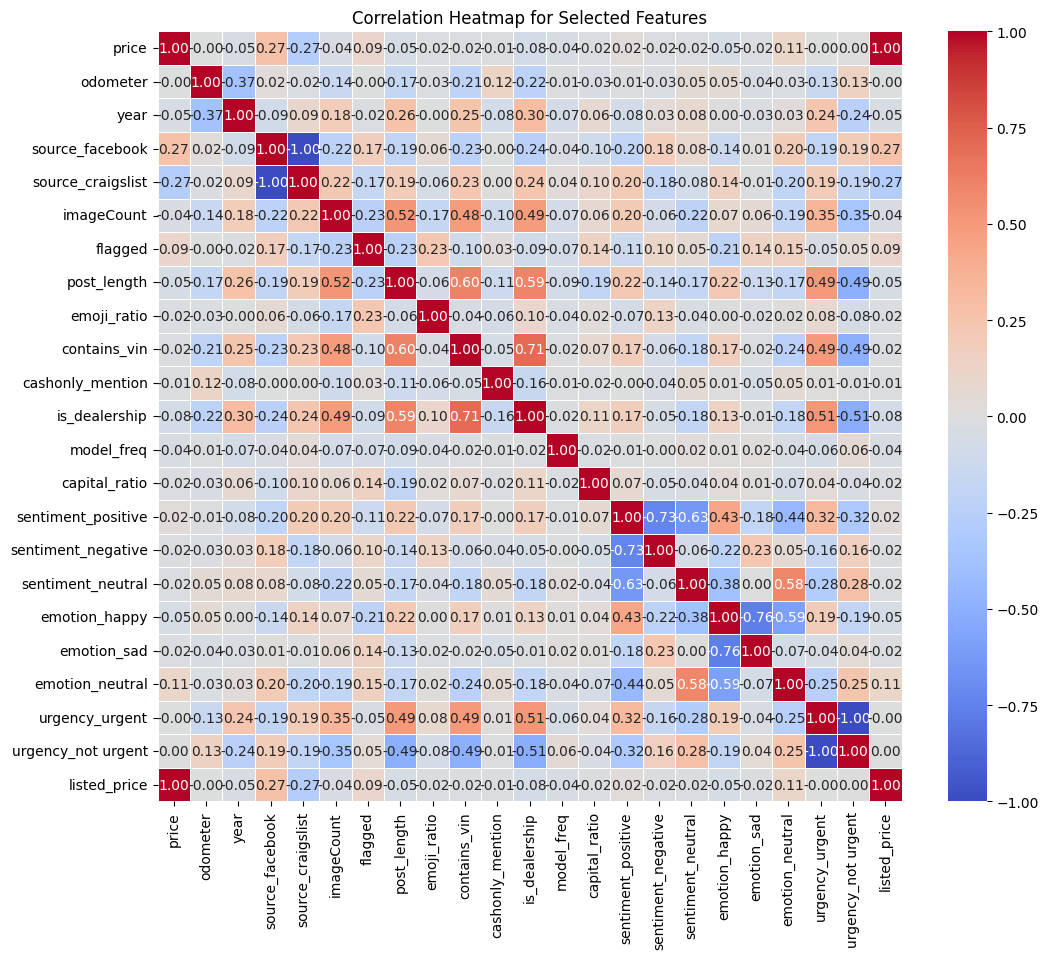

In [54]:
selected_columns = [
    "price",
    "odometer",
    "year",
    "source_facebook",
    "source_craigslist",
    "imageCount",
    "flagged",
    "post_length",
    "emoji_ratio",
    "contains_vin",
    "cashonly_mention",
    "is_dealership",
    "model_freq",
    "capital_ratio",
    "sentiment_positive",
    "sentiment_negative",
    "sentiment_neutral",
    "emotion_happy",
    "emotion_sad",
    "emotion_neutral",
    "urgency_urgent",
    "urgency_not urgent",
    "listed_price",
]

# Filter the DataFrame to include only the selected columns
filtered_data = data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = filtered_data.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))  # You can adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap for Selected Features")
plt.show()

In [55]:
# sns.boxplot(x='flagged', y='price_deviation', data=data)
# plt.title('Price Deviation by Fraud Label')
# plt.show()

# Step 3: Model Selection


In [56]:
# Split data into features and target
X = data.drop("flagged", axis=1)
y = data["flagged"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [57]:
# Initialize and train a RandomForest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Step 4: Model Training and Validation


In [58]:
# Predict on test data
y_pred = model.predict(X_test)

In [59]:
# Hyperparameter tuning (example using GridSearch)
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"],
}
CV_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5
)
CV_rfc.fit(X_train, y_train)
print("Best parameters:", CV_rfc.best_params_)

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}


/Users/waseem/.local/share/virtualenvs/backend-lPZA1A0_/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/waseem/.local/share/virtualenvs/backend-lPZA1A0_/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/waseem/.local/share/virtualenvs/backend-lPZA1A0_/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/waseem/.local/share/virtualenvs/backend-lP

# Step 5: Evaluation


In [60]:
# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.95      0.81       113
        True       0.83      0.39      0.53        74

    accuracy                           0.73       187
   macro avg       0.77      0.67      0.67       187
weighted avg       0.75      0.73      0.70       187

Confusion Matrix:
 [[107   6]
 [ 45  29]]
Accuracy Score: 0.7272727272727273
